In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import sys

y_label = 'Renewal_Flag'
df = pd.read_csv("data/Slot Performance Data.csv")
df[['StartDate','EndDate']] = df[['StartDate','EndDate']].apply(pd.to_datetime)
df['day_diff'] = (df['EndDate'] - df['StartDate']).dt.days

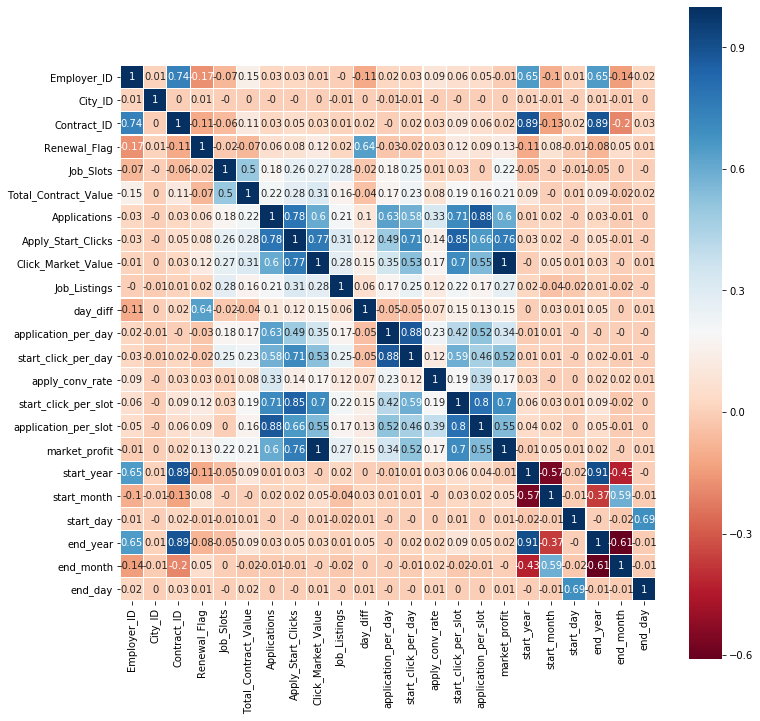

In [3]:
df_metrics = df
df_metrics['application_per_day'] = df['Applications'] / df['day_diff']
df_metrics['start_click_per_day'] = df['Apply_Start_Clicks'] / df['day_diff']
df_metrics['apply_conv_rate'] = (df['Applications'] / df['Apply_Start_Clicks']).replace(np.nan, 0)
df_metrics['start_click_per_slot'] = df['Apply_Start_Clicks'] / df['Job_Slots']
df_metrics['application_per_slot'] = df['Applications'] / df['Job_Slots']
df_metrics['market_profit'] = df['Click_Market_Value'] - df['Total_Contract_Value']

df_metrics['start_year'] = pd.DatetimeIndex(df_metrics['StartDate']).year
df_metrics['start_month'] = pd.DatetimeIndex(df_metrics['StartDate']).month
df_metrics['start_day'] = pd.DatetimeIndex(df_metrics['StartDate']).day
df_metrics['end_year'] = pd.DatetimeIndex(df_metrics['EndDate']).year
df_metrics['end_month'] = pd.DatetimeIndex(df_metrics['EndDate']).month
df_metrics['end_day'] = pd.DatetimeIndex(df_metrics['EndDate']).day

colormap = plt.cm.RdBu
f, axs = plt.subplots(1, 1, figsize=(12, 12))
#ax = plt.subplot(3, 3, idx + 1)
sns.heatmap(df_metrics.corr(method='pearson', min_periods=1).round(decimals=2), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)
#plt.xticks(rotation=30, fontsize=7)
plt.show()

([<matplotlib.axis.XTick at 0x11fe30b20>,
 <a list of 2 Text xticklabel objects>)

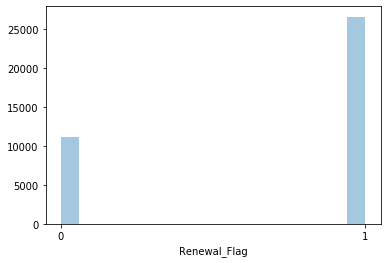

In [104]:
sns.distplot(df_metrics[y_label], kde=False)
plt.xticks([0, 1])

In [5]:
df_train = df_metrics.replace([np.inf, -np.inf], np.nan).dropna()
df_train.drop(['Employer_ID', 'City_ID', 'Contract_ID', 'StartDate', 'EndDate'], axis=1, inplace=True)
training_set, testing_test = train_test_split(df_train, test_size=0.2)
y_train, y_test = training_set[y_label], testing_test[y_label]
x_train, x_test = training_set.drop(y_label, axis=1), testing_test.drop(y_label, axis=1)
x_train

,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,day_diff,application_per_day,start_click_per_day,apply_conv_rate,start_click_per_slot,application_per_slot,market_profit,start_year,start_month,start_day,end_year,end_month,end_day
35093,15,495,40,50,1513.35,0,29,1.379310,1.724138,0.800000,3.333333,2.666667,1018.35,2017,6,18,2017,7,17
31181,15,495,5,35,868.00,10,8,0.625000,4.375000,0.142857,2.333333,0.333333,373.00,2017,12,6,2017,12,14
35536,15,995,20,30,762.85,0,30,0.666667,1.000000,0.666667,2.000000,1.333333,-232.15,2017,10,24,2017,11,23
7620,15,1745,105,130,540.00,10,30,3.500000,4.333333,0.807692,8.666667,7.000000,-1205.00,2017,7,19,2017,8,18
7109,15,995,0,125,2527.00,0,25,0.000000,5.000000,0.000000,8.333333,0.000000,1532.00,2017,10,1,2017,10,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37718,15,495,10,25,1318.25,0,30,0.333333,0.833333,0.400000,1.666667,0.666667,823.25,2016,10,26,2016,11,25
10140,15,495,55,110,6880.80,5,30,1.833333,3.666667,0.500000,7.333333,3.666667,6385.80,2016,10,22,2016,11,21
4743,15,995,45,110,3072.25,15,30,1.500000,3.666667,0.409091,7.333333,3.000000,2077.25,2018,3,10,2018,4,9
7461,15,1245,175,225,6871.65,0,30,5.833333,7.500000,0.777778,15.000000,11.666667,5626.65,2018,1,28,2018,2,27


In [6]:
def evaluate_performance(model):
    y_pred = model.predict(x_test)
    n_correct = sum(y_pred == y_test)
    print("Overall performance")
    print("accuracy: {}".format(float(n_correct) / len(y_pred)))
    print("recall: {}".format(recall_score(y_test, y_pred)))
    print("f1: {}".format(f1_score(y_test, y_pred)))
    print("\n Confusion matrix")
    print(confusion_matrix(y_test, y_pred))
    print("\n Label performance")
    print("classification_report: {}".format(classification_report(y_test, y_pred)))
    
rf_clf = RandomForestClassifier(n_estimators=500)
rf_clf.fit(x_train, y_train)
evaluate_performance(rf_clf)

Overall performance
accuracy: 0.9306127874518144
recall: 0.9904422788605697
f1: 0.9529390551749007

 Confusion matrix
[[1716  471]
 [  51 5285]]

 Label performance
classification_report:               precision    recall  f1-score   support

           0       0.97      0.78      0.87      2187
           1       0.92      0.99      0.95      5336

    accuracy                           0.93      7523
   macro avg       0.94      0.89      0.91      7523
weighted avg       0.93      0.93      0.93      7523



Feature ranking:
1. feature day_diff (0.4875259540664146)
2. feature end_month (0.0656643963929047)
3. feature Click_Market_Value (0.06423705791711305)
4. feature start_month (0.050116473855049186)
5. feature start_click_per_day (0.040357618088312154)
6. feature end_day (0.036793948209534355)
7. feature start_day (0.035728147050117426)
8. feature start_year (0.03383596182872068)
9. feature Total_Contract_Value (0.026524683313052844)
10. feature Apply_Start_Clicks (0.026346070848037282)
11. feature start_click_per_slot (0.026317228759936674)
12. feature application_per_day (0.024953740128806943)
13. feature end_year (0.020527731789404174)
14. feature apply_conv_rate (0.018545079977522087)
15. feature Applications (0.014547438349292672)
16. feature application_per_slot (0.014528305603363389)
17. feature Job_Listings (0.01148501608353638)
18. feature Job_Slots (0.0019651477388812734)


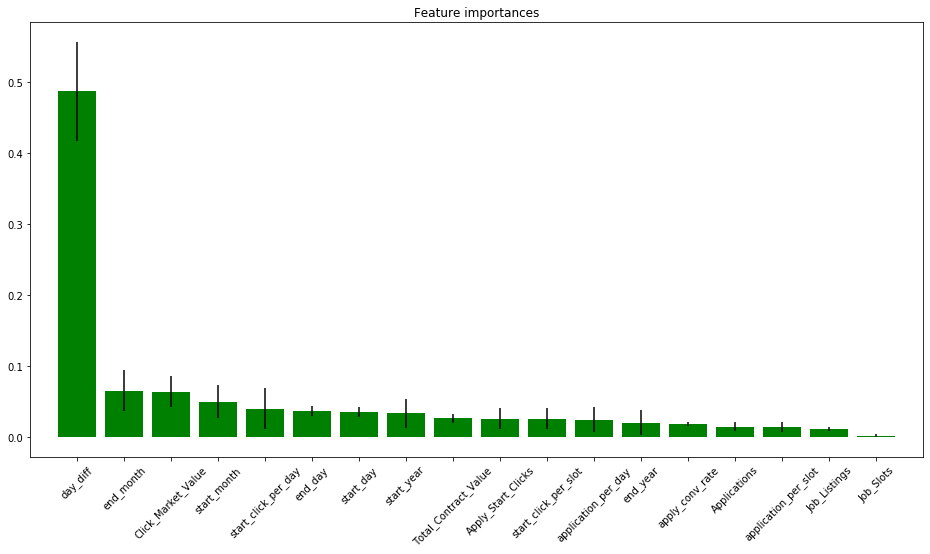

In [87]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = []

print("Feature ranking:")
for f in range(x_train.shape[1]):
    feature_name = x_train.columns[indices[f]]
    feature_names.append(feature_name)
    print("{}. feature {} ({})".format(f + 1, feature_name, importances[indices[f]]))

# Plot the feature importances of the forest
f, axs = plt.subplots(1, 1, figsize=(16, 8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), feature_names)
plt.xlim([-1, x_train.shape[1]])
plt.xticks(rotation=45)
plt.show()

In [11]:
gb_clf = GradientBoostingClassifier(n_estimators=1000)
gb_clf.fit(x_train, y_train)
evaluate_performance(gb_clf)

Overall performance
accuracy: 0.9334042270370863
recall: 0.9943138741470812
f1: 0.9544255435276995

 Confusion matrix
[[1776  471]
 [  30 5246]]

 Label performance
classification_report:               precision    recall  f1-score   support

           0       0.98      0.79      0.88      2247
           1       0.92      0.99      0.95      5276

    accuracy                           0.93      7523
   macro avg       0.95      0.89      0.92      7523
weighted avg       0.94      0.93      0.93      7523



Feature ranking:
1. feature day_diff (0.6931774934953555)
2. feature end_month (0.1412048011494372)
3. feature start_year (0.05928139738367444)
4. feature Click_Market_Value (0.03747814396040809)
5. feature start_month (0.011708951754668897)
6. feature apply_conv_rate (0.009685878520478272)
7. feature start_day (0.009408569779130616)
8. feature start_click_per_day (0.006716393479264069)
9. feature Total_Contract_Value (0.005699463321951191)
10. feature start_click_per_slot (0.0046202899410910745)
11. feature Apply_Start_Clicks (0.004205497979942377)
12. feature end_day (0.004187367888585296)
13. feature application_per_day (0.0033687354397798183)
14. feature Job_Listings (0.003356927741349666)
15. feature application_per_slot (0.002625917337791648)
16. feature Applications (0.0017517814421153662)
17. feature end_year (0.0009883721047965173)
18. feature Job_Slots (0.0005340172801798628)


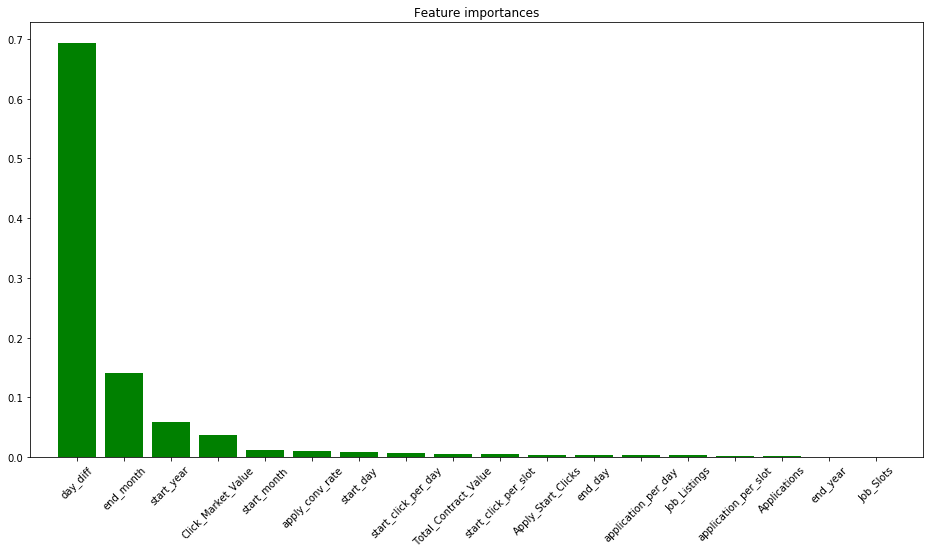

In [97]:
importances = gb_clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in gb_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = []

print("Feature ranking:")
for f in range(x_train.shape[1]):
    feature_name = x_train.columns[indices[f]]
    feature_names.append(feature_name)
    print("{}. feature {} ({})".format(f + 1, feature_name, importances[indices[f]]))

# Plot the feature importances of the forest
f, axs = plt.subplots(1, 1, figsize=(16, 8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="g", align="center")
plt.xticks(range(x_train.shape[1]), feature_names)
plt.xlim([-1, x_train.shape[1]])
plt.xticks(rotation=45)
plt.show()

In [8]:
def dict_product(d):
    keys = d.keys()
    for element in product(*d.values()):
        yield dict(zip(keys, element))
        
def GridSearchWithVal(model_class, param_grid, metrics='accuracy', cv=5):
    combinations = list(dict_product(param_grid))
    max_metrics = 0
    best_comb = None
    X = x_train
    Y = y_train
    _x_test = x_test_smote if smote is True else x_test
    _y_test = y_test_smote if smote is True else y_test
    print("{} combinations in total. Metric: {}".format(len(combinations), metrics))
    for idx, comb in enumerate(combinations):
        model = model_class(**comb)
        model.fit(X, Y)
        y_preds = model.predict(_x_test)
        # print("y_preds:{}".format(y_preds))
        # print("y_test:{}".format(y_test.values))
        error = 0;

        #scores = cross_val_score(model, X, Y, cv=cv, scoring=metrics)
        n_correct = sum(y_preds == _y_test)
        acc = float(n_correct) / len(y_preds)
        metrics_num = acc

        if metrics_num > max_metrics:
            max_metrics = metrics_num
            best_comb = comb
        progress_str = "{} / {}, best comb: {}, best score: {}".format(idx + 1, len(combinations), best_comb, max_metrics)
        sys.stdout.write('\r' + progress_str)

    print("best params:{}".format(best_comb))
    print("max {}: {}".format(metrics, max_metrics))
    return best_comb

In [12]:
rf_param_grid = {"n_estimators" : [50, 100, 200, 500, 1000],
                  "criterion" : ["gini", "entropy"],
                  "max_depth": [None],
                  "max_features": [0.1, 0.2, 0.5, 0.8, None],
                  "min_samples_split": [2, 3, 4, 5],
                  "min_samples_leaf": [1, 3, 5, 10],
                  "bootstrap": [True, False]
                 }
rf_best = GridSearchWithVal(RandomForestClassifier, rf_param_grid)

1600 combinations in total. Metric: accuracy
14 / 1600, best comb: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.1, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}, best score: 0.9259603881430281

KeyboardInterrupt: 